In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import pickle, shutil, random
import os

In [32]:
BASE_PATH = Path('/project/volume/data/out/FER-2013')

IMAGE_PATHS = list(BASE_PATH.rglob('*.jpg'))
IMAGE_PATHS_STR = [str(path) for path in IMAGE_PATHS]

LABELS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

ORIG_FOLDERS = ['train', 'test']

In [4]:
def remove_ipynb_checkpoints(path):
    for checkpoint_dir in Path(path).rglob('.ipynb_checkpoints'):
        print("Removing directory:", checkpoint_dir)
        for file in os.listdir(checkpoint_dir):
            file_path = os.path.join(checkpoint_dir, file)
            os.unlink(file_path)
        os.rmdir(checkpoint_dir)

In [5]:
remove_ipynb_checkpoints(BASE_PATH)

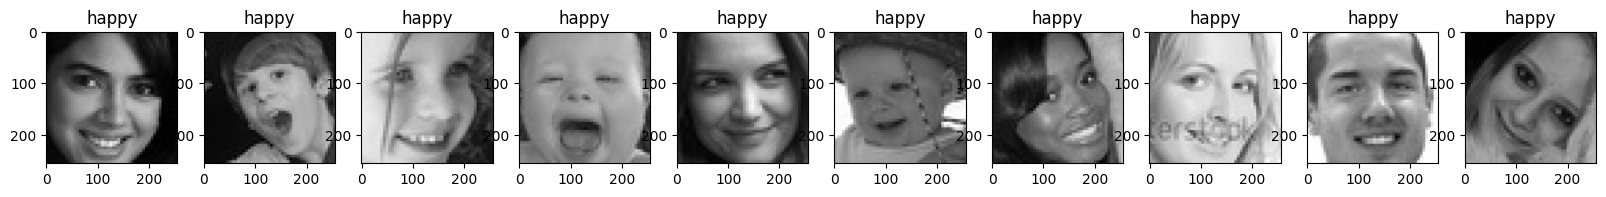

In [6]:
fig = plt.figure(figsize=(20,20))

for i in range(10):

    fig.add_subplot(1, 10, i + 1)
    plt.imshow(np.array(cv2.imread(str(IMAGE_PATHS[i]))), cmap='gray')
    label = Path(IMAGE_PATHS[i]).parent.name
    plt.title(label)

plt.show()

{'happy': 8989, 'sad': 6077, 'fear': 5121, 'surprise': 4002, 'neutral': 6198, 'angry': 4953, 'disgust': 547}


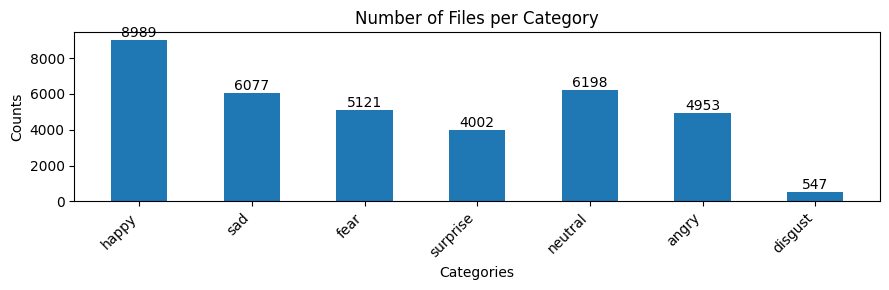

In [9]:
def get_distribution():
    nbr_per_cat = Counter(Path(file).parent.name for file in IMAGE_PATHS)
    print(dict(nbr_per_cat))

    categories = list(nbr_per_cat.keys())
    counts = list(nbr_per_cat.values())

    plt.figure(figsize=(9, 3))
    bars = plt.bar(categories, counts, width=0.5)

    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title('Number of Files per Category')
    plt.xticks(rotation=45, ha='right')

    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), 
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

get_distribution()

In [20]:
train_prop = 0.6
test_prop = 0.2
valid_prop = 0.2

number_of_images = len(list(BASE_PATH.rglob('*.jpg')))

n_train = int((number_of_images * train_prop) + 0.5)
n_valid = int((number_of_images * valid_prop) + 0.5)
n_test = number_of_images - n_train - n_valid

print(f"[INFO] Number of images used in training ... {str(n_train)} ({str(train_prop * 100)}%)")
print(f"[INFO] Number of images used in validation ...{str(n_valid)} ({str(valid_prop * 100)}%)")
print(f"[INFO] Number of images used in testing ... {str(n_test)} ({str(test_prop * 100)}%)")

[INFO] Number of images used in training ... 21532 (60.0%)
[INFO] Number of images used in validation ...7177 (20.0%)
[INFO] Number of images used in testing ... 7178 (20.0%)


In [30]:
def split_and_move():
    for label in tqdm(LABELS):
        train_destination = BASE_PATH / "train" / label
        val_destination = BASE_PATH / "val" / label
        test_destination = BASE_PATH / "test" / label

        train_destination.mkdir(parents=True, exist_ok=True)
        val_destination.mkdir(parents=True, exist_ok=True)
        test_destination.mkdir(parents=True, exist_ok=True)

        files = list((BASE_PATH / "train").rglob('*.jpg'))
        random.shuffle(files)

        train_n = (int((len(files) * train_prop) + 0.5))
        val_n = (int((len(files) * valid_prop) + 0.2))
        
        for file_idx, file in enumerate(files):
            if file_idx < train_n:
                shutil.move(str(file), train_destination)
            elif file_idx < train_n + val_n:
                shutil.move(str(file), val_destination)
            else:
                shutil.move(str(file), test_destination)

        if BASE_PATH.exists() and BASE_PATH.is_dir():
            shutil.rmtree(BASE_PATH)

In [31]:
split_and_move()

  0%|                                                                                        | 0/7 [00:00<?, ?it/s]

/project/volume/data/out/FER-2013/test/happy/PrivateTest_45699463.jpg


## HOG features

In [43]:
def print_score(clf, x_train, y_train, x_test, y_test, train=True):
    if train:
        y_prediction = clf.predict(x_train)
        clf_report = classification_report(y_train, y_prediction)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, y_prediction)}\n")
        
    elif train==False:
        y_prediction = clf.predict(x_test)
        clf_report = classification_report(y_test, y_prediction)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_prediction)}\n")

In [44]:
def to_grayscale(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def resize_image(img, size):
    return cv2.resize(img, (size,size))

In [45]:
def extract_hog_features():
    hog_data = []
    hog_labels = []

    for p in tqdm(IMAGE_PATHS):
        im = to_grayscale(str(p))
        im = resize_image(im, 128)
        
        # extract hog feature descriptor
        fd1 = hog(im, orientations=7, pixels_per_cell=(8, 8),
                  cells_per_block=(4, 4), 
                  block_norm='L2-Hys',
                  transform_sqrt=False,
                  feature_vector=True)

        label = Path(p).parent.name
        hog_labels.append(label)
        hog_data.append(fd1)

    hog_data = np.array(hog_data)
    hog_labels = np.array(hog_labels)
    print("[INFO] Number of features ...", str(hog_data.shape[1]))
    print("[INFO] Number of labels ...", str(hog_labels.shape[0]))
    return hog_data, hog_labels

def compute_hog_feature_size(image_shape, orientations, pixels_per_cell, cells_per_block):
    height, width = image_shape, image_shape
    num_cells_x = width // pixels_per_cell
    num_cells_y = height // pixels_per_cell
    num_blocks_x = num_cells_x - cells_per_block + 1
    num_blocks_y = num_cells_y - cells_per_block + 1
    features_per_block = cells_per_block * cells_per_block * orientations
    total_features = num_blocks_x * num_blocks_y * features_per_block
    print("[INFO] Size of HOG feature vector ...", total_features)

# Parameters
orientations = 7
pixels_per_cell = 8
cells_per_block = 4
image_shape = 64

compute_hog_feature_size(image_shape, orientations, pixels_per_cell, cells_per_block)

[INFO] Size of HOG feature vector ... 2800


In [46]:
hog_data, hog_labels = extract_hog_features()

x_train, x_test, y_train, y_test = train_test_split(hog_data, hog_labels, test_size=0.2, shuffle=True, stratify=hog_labels, random_state=42)
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_estimator_hog = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)

pickle.dump(best_estimator_hog, open('/project/volume/models/hog_model.p', 'wb'))

print_score(best_estimator_hog, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator_hog, x_train, y_train, x_test, y_test, train=False)

 38%|██████████████████████████▉                                            | 13624/35887 [02:06<02:33, 144.83it/s]

## Landmarks

In [ ]:
from mediapipe import Image
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

import mediapipe as mp

In [ ]:
model_path_mesh = '/project/volume/models/face_landmarker.task'

base_options_mesh = python.BaseOptions(model_asset_path=model_path_mesh)
options_mesh = vision.FaceLandmarkerOptions(base_options=base_options_mesh,
                                       output_face_blendshapes=False,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector_mesh = vision.FaceLandmarker.create_from_options(options_mesh)

In [ ]:
def read_mp_cv2_image(image_path):
    return Image.create_from_file(str(image_path)), cv2.imread(str(image_path))

def colortogray(img):
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return imgray

def resizeImage(image, size):
    return cv2.resize(image, (size,size))

In [ ]:
def extract_landmarks():
    lm_labels = []
    lm_data = []

    for file in tqdm(IMAGE_PATHS):
        img_cv2 = to_grayscale(str(file))
        img_cv2 = resize_image(img_cv2, 128)
        rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
        detection_result = detector_mesh.detect(rgb_frame)

        if detection_result.face_landmarks:
            lm_array = np.array([[lm.x, lm.y, lm.z] for lm in detection_result.face_landmarks[0]]).flatten()
            lm_labels.append(file.parent.name)
            lm_data.append(lm_array)

    lm_labels = np.array(lm_labels)
    lm_data = np.array(lm_data)

    return lm_data, lm_labels

In [ ]:
lm_data, lm_labels = extract_landmarks()

x_train, x_test, y_train, y_test = train_test_split(lm_data, lm_labels, test_size=0.2, shuffle=True, stratify=hog_labels, random_state=42)
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_estimator_landmark = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)
pickle.dump(best_estimator_landmark, open('/project/volume/models/lm_model.p', 'wb'))

print_score(best_estimator_landmark, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator_landmark, x_train, y_train, x_test, y_test, train=False)

## Pure Images

In [ ]:
def pure_pixels():
    pixel_labels = []
    pixel_data = []

    for file in tqdm(IMAGE_PATHS):     
        img_cv2 = to_grayscale(str(file))
        img_cv2 = resize_image(img_cv2, 128)
        
        pixel_labels.append(file.parent.name)
        pixel_data.append(np.array(img_cv2).flatten())

    pixel_labels = np.array(pixel_labels)
    pixel_data = np.array(pixel_data)

    return pixel_data, pixel_labels

In [ ]:
pixel_data, pixel_labels = pure_pixels()

x_train, x_test, y_train, y_test = train_test_split(pixel_data, pixel_labels, test_size=0.2, shuffle=True, stratify=hog_labels, random_state=42)
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_estimator_pixel = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)
pickle.dump(best_estimator_pixel, open('/project/volume/models/pixel_model.p', 'wb'))

print_score(best_estimator_pixel, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator_pixel, x_train, y_train, x_test, y_test, train=False)

### K-fold cross validation

In [ ]:
n_splits_values = [3, 5, 10]

In [ ]:
classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

modes = {'hog': best_estimator_hog, 
         'pixel': best_estimator_pixel,
         'landmark': best_estimator_landmark
        }

for mode, model in modes.items():
    print(mode)
    for n_splits in n_splits_values:
        cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
        scores = cross_val_score(model, lm_data, lm_labels, scoring='accuracy', cv=cv, n_jobs=-1)
        print(f"{n_splits}-Fold CV: {scores.mean():.2f} accuracy with a standard deviation of {scores.std():.2f}")